# pneumonia detection from chest x-rays  with transfer learning (mobilenetv2)

## dependencies


In [30]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
import tensorflow as tf

## dataset


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip

In [17]:
!mv chest_xray/chest_xray /content/chest_xray_clean

In [18]:
!find /content/chest_xray_clean -name "__MACOSX" -exec rm -rf {} +
!find /content/chest_xray_clean -name ".DS_Store" -delete

In [21]:
!rm -rf /content/chest_xray

In [22]:
base = "/content/chest_xray_clean"
for split in ["train", "test", "val"]:
    split_dir = os.path.join(base, split)
    classes = [c for c in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, c))]
    counts = {c: len(os.listdir(os.path.join(split_dir, c))) for c in classes}
    print(split, counts)

train {'NORMAL': 1341, 'PNEUMONIA': 3875}
test {'NORMAL': 234, 'PNEUMONIA': 390}
val {'NORMAL': 8, 'PNEUMONIA': 8}


## exploration and preprocessing

In [26]:
import os

base = "/content/chest_xray_clean"
for split in ["train", "val", "test"]:
    print(f"\n{split}:")
    split_dir = os.path.join(base, split)
    for cls in os.listdir(split_dir):
        cls_dir = os.path.join(split_dir, cls)
        if os.path.isdir(cls_dir):
            print(f"  {cls}: {len(os.listdir(cls_dir))} images")



train:
  NORMAL: 1341 images
  PNEUMONIA: 3875 images

val:
  NORMAL: 8 images
  PNEUMONIA: 8 images

test:
  NORMAL: 234 images
  PNEUMONIA: 390 images


In [37]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

def show_samples(folder, n=6):
    classes = os.listdir(folder)
    imgs = []

    # collect random image paths
    for _ in range(n):
        c = random.choice(classes)
        f = random.choice(os.listdir(os.path.join(folder, c)))
        imgs.append((os.path.join(folder, c, f), c))

    plt.figure(figsize=(12, 6))

    # display images + print dimensions
    for i, (p, c) in enumerate(imgs):
        img = Image.open(p).convert("L")
        w, h = img.size

        print(f"{c}: {os.path.basename(p)} -> {w}x{h}")

        plt.subplot(2, 3, i+1)
        plt.imshow(img, cmap="gray")
        plt.title(f"{c}\n{w}x{h}")
        plt.axis("off")

    plt.show()

NORMAL: NORMAL2-IM-0870-0001.jpeg -> 1480x1228
NORMAL: IM-0663-0001.jpeg -> 1246x931
PNEUMONIA: person31_bacteria_162.jpeg -> 944x480
NORMAL: IM-0131-0001.jpeg -> 1450x1144
NORMAL: IM-0448-0001.jpeg -> 1954x1279
NORMAL: NORMAL2-IM-1222-0001.jpeg -> 1364x1148


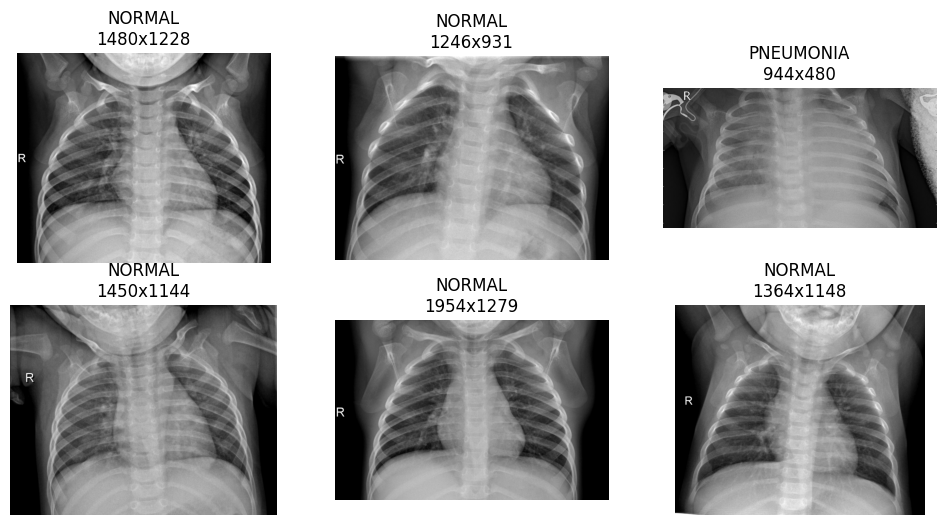

In [38]:
show_samples("/content/chest_xray_clean/train")

In [39]:
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
data_dir = "/content/chest_xray_clean"

In [40]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, "train"),
    label_mode = "binary",
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 21
)

Found 5216 files belonging to 2 classes.


In [41]:
# test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, "test"),
    label_mode = "binary",
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    shuffle = False,
)

Found 624 files belonging to 2 classes.


In [42]:
# val dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, "val"),
    label_mode = "binary",
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    shuffle = False,
)

Found 16 files belonging to 2 classes.


In [43]:
# data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.08),
    tf.keras.layers.RandomZoom(0.08),
    tf.keras.layers.RandomTranslation(0.05, 0.05),
])

In [44]:
# preprocessing input to use mobilenetv2
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [45]:
# wraping the pipeloine
def prepare(ds, training=False):
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32), y), num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x,y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x,y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

train_ds = prepare(train_ds, training=True)
val_ds = prepare(val_ds, training=False)
test_ds = prepare(test_ds, training=False)

In [47]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [ ]:
# handling class imbalances and sample weighting